In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ----------------------------------- Model ---------------------------------- #
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, GaussianNoise
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils import class_weight

import os
os.chdir("../")
from Sources.tools import *

# Data preprocessing

In [2]:
df = get_technical_df()
df = compute_indicators(df)

In [3]:
df

,open,high,low,close,volume,SMA_20,EMA_20,Bollinger_Mid,Bollinger_Std,Bollinger_Upper,Bollinger_Lower,RSI
0,5107.4702,5116.7998,5086.3301,5116.7700,2047460000,5056.798545,5065.295675,5056.798545,69.063593,5194.925732,4918.671358,66.942128
1,5157.8301,5162.4600,5128.8999,5152.6899,2239570000,5068.866535,5073.618934,5068.866535,63.140268,5195.147070,4942.586000,69.579660
2,5141.2700,5162.5601,5128.7598,5147.7002,2077010000,5079.391045,5080.674293,5079.391045,57.314080,5194.019205,4964.762885,70.602164
3,5153.6099,5165.4702,5147.5801,5161.6001,1792330000,5089.223540,5088.381513,5089.223540,53.381070,5195.985680,4982.461400,70.117893
4,5154.1802,5167.9600,5148.0601,5167.9600,1736140000,5097.267535,5095.960416,5097.267535,52.465027,5202.197590,4992.337480,75.141714
...,...,...,...,...,...,...,...,...,...,...,...,...
1486,10911.0400,11007.0898,10830.9004,10985.4502,3544680000,11519.855410,11386.909636,11519.855410,341.364356,12202.584122,10837.126698,30.054731
1487,10944.2998,10957.4404,10807.6104,10822.5098,3827290000,11481.593400,11333.157271,11481.593400,374.620119,12230.833638,10732.353162,31.206913
1488,10807.1201,10898.6396,10671.1904,10679.3398,3842970000,11440.387880,11270.888940,11440.387880,415.213304,12270.814487,10609.961273,29.806939
1489,10800.7998,10981.0596,10776.6201,10951.0498,4154100000,11386.437390,11240.428070,11386.437390,404.524775,12195.486939,10577.387841,34.089112


In [4]:
# Normalization and split
train_df, test_df, val_df, scaler = get_scaled_split(df)

Train size: 1043
Validation size: 149
Test size: 299


In [5]:
# Creating input sequences for training
def create_sequences(data, seq_length=60):
    X = []
    y = []
    for i in range(seq_length, len(data)):
        X.append(data[i-seq_length:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

X_train, y_train = create_sequences(train_df)
X_test, y_test = create_sequences(test_df)
X_val, y_val = create_sequences(val_df)

# Reshape inputs for LSTM model
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
X_val = np.reshape(X_val, (X_val.shape[0], X_val.shape[1], 1))

# LSTM

In [6]:
# Création du modèle
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    Dropout(0.2),
    LSTM(50),
    Dropout(0.2),
    Dense(1)  # 1 sortie par pas de temps à prédire
])


# Optimizer
model.compile(optimizer="adam", loss='mse', metrics=['mse'])

# Affichage du modèle
model.summary()

c:\Users\planc\anaconda3\envs\env_dl_project\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,651 (119.73 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)

In [7]:
# Entraînement
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, batch_size=32, callbacks=[early_stopping])

Epoch 1/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0393 - mse: 0.0393 - val_loss: 0.0037 - val_mse: 0.0037
Epoch 2/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0035 - mse: 0.0035 - val_loss: 0.0019 - val_mse: 0.0019
Epoch 3/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0029 - mse: 0.0029 - val_loss: 0.0012 - val_mse: 0.0012
Epoch 4/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0024 - mse: 0.0024 - val_loss: 0.0014 - val_mse: 0.0014
Epoch 5/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0023 - mse: 0.0023 - val_loss: 0.0031 - val_mse: 0.0031
Epoch 6/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0023 - mse: 0.0023 - val_loss: 0.0049 - val_mse: 0.0049
Epoch 7/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0028 - mse: 0.0028 - val_loss: 0.0010 - val_mse: 0.0010
Epoch 8/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0024 - mse: 0.0024 - val_loss: 0.0052 - val_mse: 0.0052
Epoch 9/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - lo

# Results

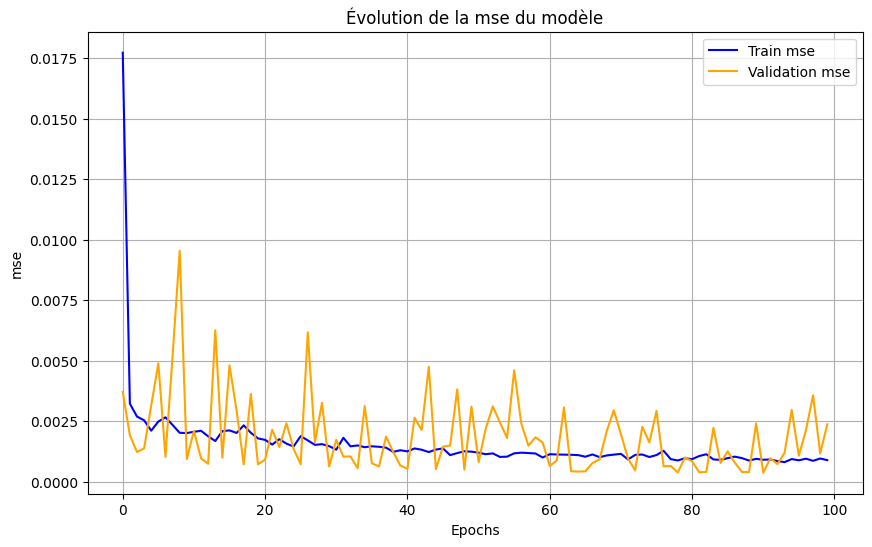

In [8]:
plot_training_curves(history, "mse")

## Train

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
----- Résultats des métriques -----
RMSE : 0.019988189612758226
MAE : 0.013658805889949346
R² : 0.9932356077334111
NMAE : 0.03899239030756128
Model Accuracy: 96.95%
MAPE: 5.23%
SMAPE : 4.99%


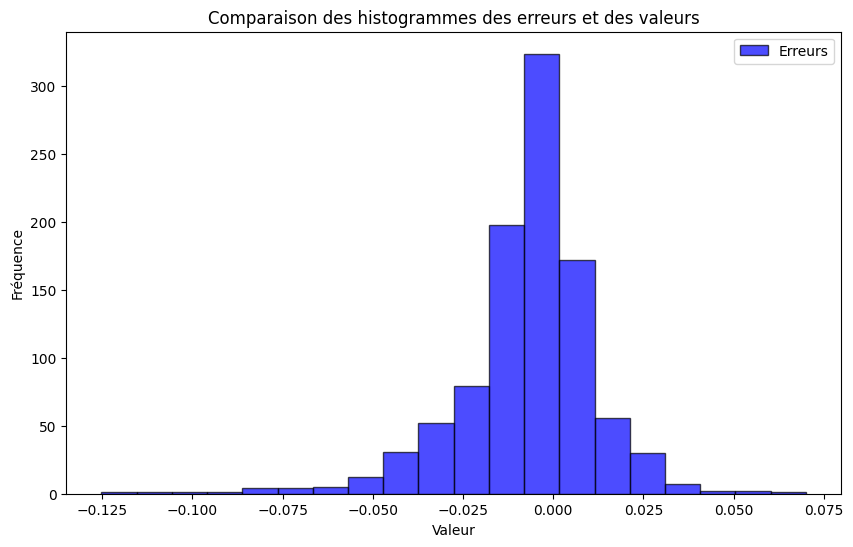

In [9]:
y_pred_train = model.predict(X_train)

y_pred_train_flat = y_pred_train.flatten()
y_train_flat = y_train.flatten()

get_performance_metrics(y_train_flat, y_pred_train_flat)
plot_errors_hist(y_train_flat, y_pred_train_flat)

## Test

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
----- Résultats des métriques -----
RMSE : 0.04314959159145967
MAE : 0.034997645925516255
R² : 0.9077392865224756
NMAE : 0.04074520521981449
Model Accuracy: 74.90%
MAPE: 4.22%
SMAPE : 4.12%


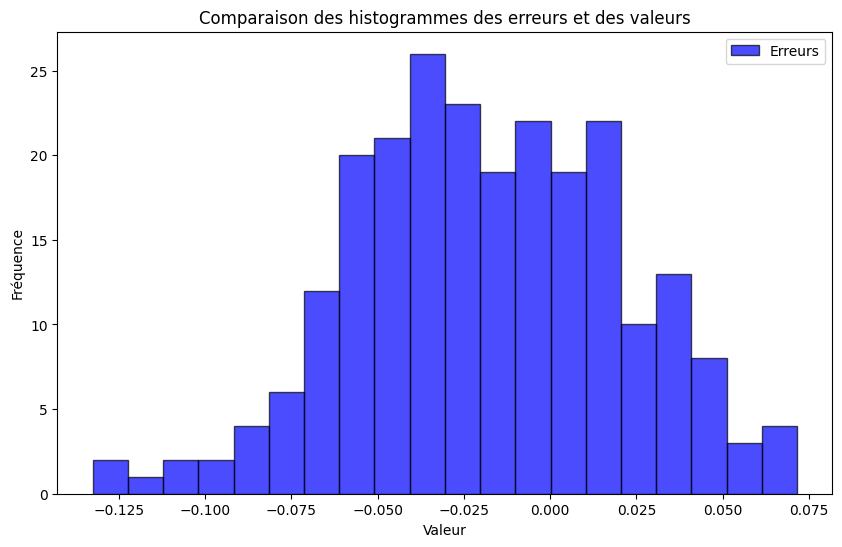

In [10]:
y_pred_test = model.predict(X_test)

y_pred_test_flat = y_pred_test.flatten()
y_test_flat = y_test.flatten()

get_performance_metrics(y_test_flat, y_pred_test_flat)
plot_errors_hist(y_test_flat, y_pred_test_flat)

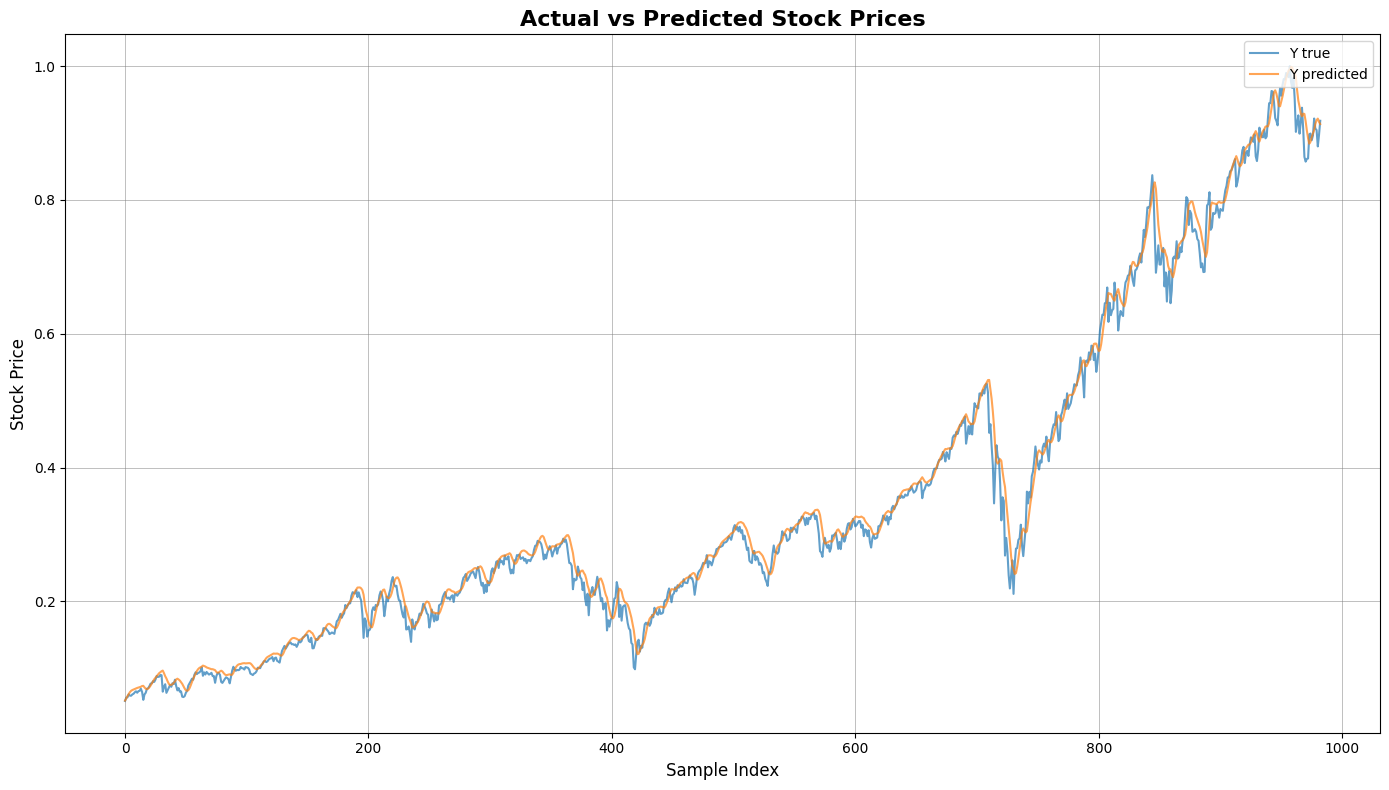

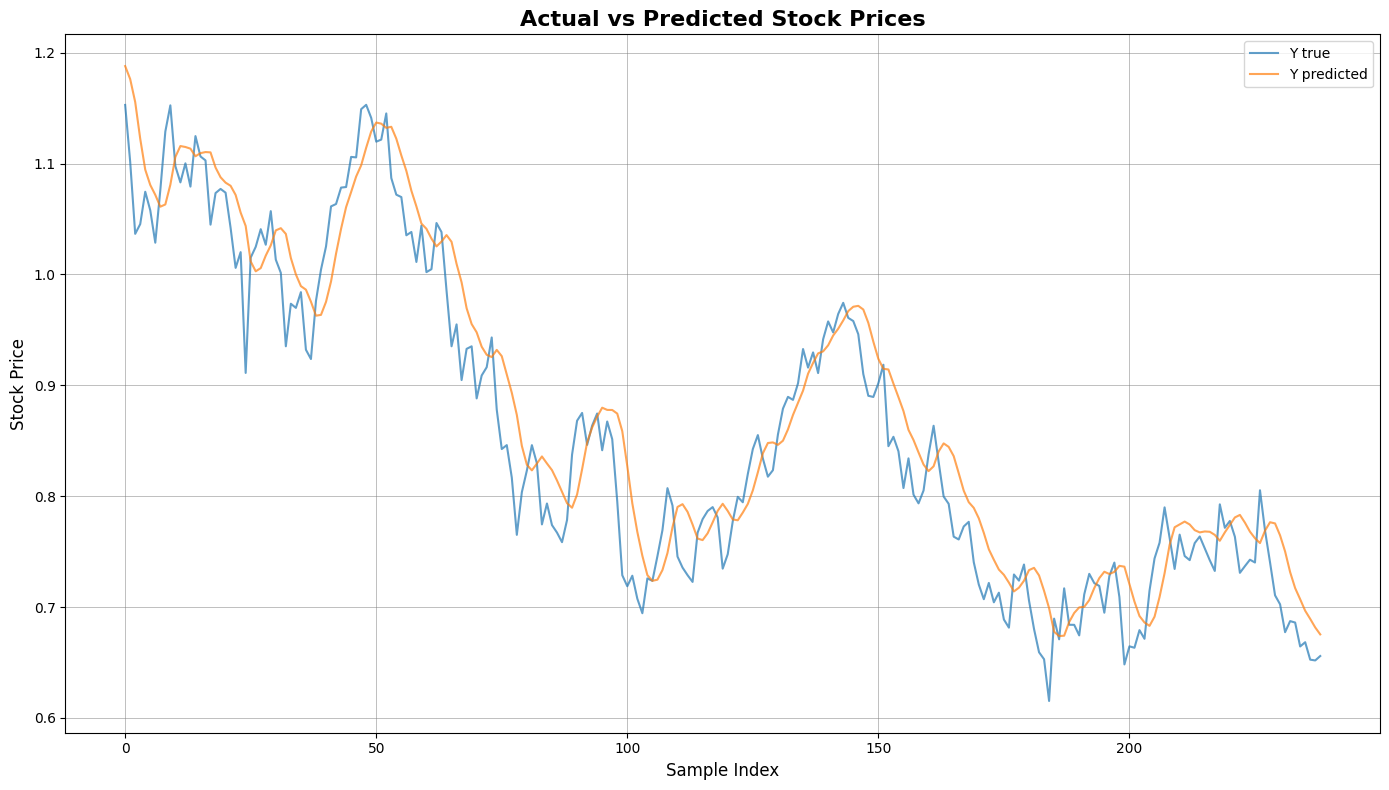

In [11]:
def plot_predictions(y_test, y_pred):
    """
    Affiche les vraies valeurs et les prédictions des prix d'actions en respectant la temporalité.
    
    Paramètres :
    - y_test : np.array de forme (N, 3), valeurs réelles
    - y_pred : np.array de forme (N, 3), valeurs prédites
    """
    plt.figure(figsize=(14, 8))

    plt.plot(y_test, label="Y true", alpha=0.7, linewidth=1.5)
    plt.plot(y_pred, label="Y predicted", alpha=0.7, linewidth=1.5)

    # Ajout des détails
    plt.grid(color='gray', linewidth=0.5, alpha=0.7)
    plt.title("Actual vs Predicted Stock Prices", fontsize=16, fontweight='bold')
    plt.xlabel("Sample Index", fontsize=12)
    plt.ylabel("Stock Price", fontsize=12)
    plt.legend(loc="upper right", fontsize=10)
    plt.tight_layout()

    # Affichage
    plt.show()

# Exemple d'utilisation avec une fenêtre de 500 échantillons
plot_predictions(y_train_flat, y_pred_train_flat)
plot_predictions(y_test_flat, y_pred_test_flat)